# Topology
This example reproduces the topology constraint.

In [22]:
from quadcoil import quadcoil
from quadcoil.objective import K_theta, Phi_with_net_current, K2, K

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready
import time

In [3]:
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.geo import SurfaceRZFourier 
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

## Loading data

In [4]:
winding_surface, plasma_surface = load('surfaces.json')
cp = CurrentPotentialFourier(
    winding_surface, mpol=4, ntor=4,
    net_poloidal_current_amperes=11884578.094260072,
    net_toroidal_current_amperes=0,
    stellsym=True)

/home/lankef/code/simsopt/src/simsopt/_core/optimizable.py:1630: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, "rt") as fp:


In [5]:
if cp.net_poloidal_current_amperes > 0:
    K_theta_sign = '>='
else:
    K_theta_sign = '<='
print('K_theta constraint sign: ' + K_theta_sign)

K_theta constraint sign: >=


In [7]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running nescoil, with auto-generated '\
      'winding surface.')
nescoil_phi_mn, nescoil_out_dict, nescoil_qp, _ = quadcoil(
    nfp=cp.nfp,
    stellsym=cp.stellsym,
    mpol=cp.mpol,
    ntor=cp.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name=('f_B_normalized_by_Bnormal_IG',),
    objective_weight=(1,),
    objective_unit=(1,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running nescoil, with auto-generated winding surface.


In [8]:
K_theta_scale = cp.net_poloidal_current_amperes / plasma_surface.get_dofs()[0]
K_theta_scale2 = jnp.max(jnp.abs(K_theta(nescoil_qp, nescoil_phi_mn)))
print('K_theta measurement from nescoil    ', K_theta_scale2)
print('Net poloidal current/major-minor rad', K_theta_scale)

K_theta measurement from nescoil     43346175.26517462
Net poloidal current/major-minor rad 8623260.843317423


In [41]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running quadcoil, with auto-generated '\
      'winding surface and K_theta constraint.')
phi_mn, out_dict, qp, status = quadcoil(
    nfp=cp.nfp,
    stellsym=cp.stellsym,
    mpol=cp.mpol,
    ntor=cp.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name=('f_B_normalized_by_Bnormal_IG',),
    objective_weight=(1,),
    objective_unit=(1,),
    # Set the constraint to K_theta
    constraint_name=('K_theta',),
    constraint_type=(K_theta_sign,),
    constraint_value=(0.,),
    constraint_unit=(K_theta_scale,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K'),
    maxiter_inner=1500,
    maxiter_outer=10,
    ftol_inner=0,
    xtol_inner=0,
)

Running quadcoil, with auto-generated winding surface and K_theta constraint.


In [42]:
status

{'c_k': Array(0.25937425, dtype=float64, weak_type=True),
 'conv': Array(1.26353338e-10, dtype=float64),
 'count_k': Array(2, dtype=int32),
 'current_niter': Array(11, dtype=int64, weak_type=True),
 'df_k': Array(4.54747351e-13, dtype=float64),
 'du_k': Array(4.75156755e-12, dtype=float64),
 'dx_k': Array(1.96302412e-12, dtype=float64),
 'f_k': Array(0.77912547, dtype=float64),
 'lam_k': Array([-2.19697681, -2.19695875, -2.19690268, ..., -2.19704921,
        -2.19711796, -2.19708456], dtype=float64),
 'mu_k': Array([0.], dtype=float64),
 'x_k': Array([ 1.62288883e-14,  5.45733880e-15, -3.84698838e-14, -1.21275756e-12,
         1.39597442e-12,  1.73670488e-14,  2.10157569e-15,  4.28942331e-15,
        -2.00648002e-02,  1.64579695e-14, -4.52618178e-15, -7.60944423e-14,
        -4.35602706e-13,  3.26874898e-13, -1.91318125e-15, -1.91617640e-15,
         2.84160823e-14,  1.00780901e-03,  5.05908345e-14,  1.37451404e-15,
        -7.37919995e-14,  7.50050716e-13,  7.55227059e-13,  4.66609926

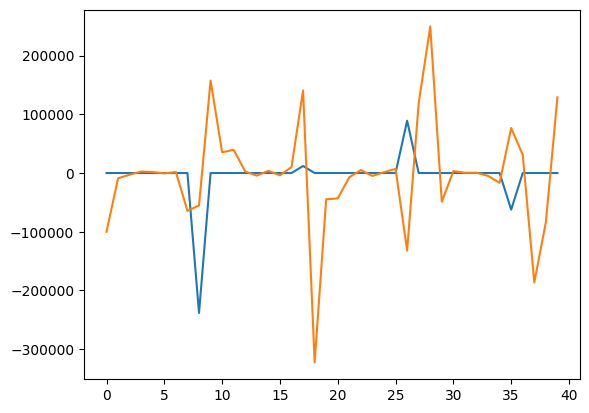

In [34]:
plt.plot(phi_mn)
plt.plot(nescoil_phi_mn)

In [35]:
print('f_B with K_theta constraints:', out_dict['f_B']['value'])
print('f_B with no constraints     :', nescoil_out_dict['f_B']['value'])

f_B with K_theta constraints: 0.9600713172195954
f_B with no constraints     : 0.03728600456445115


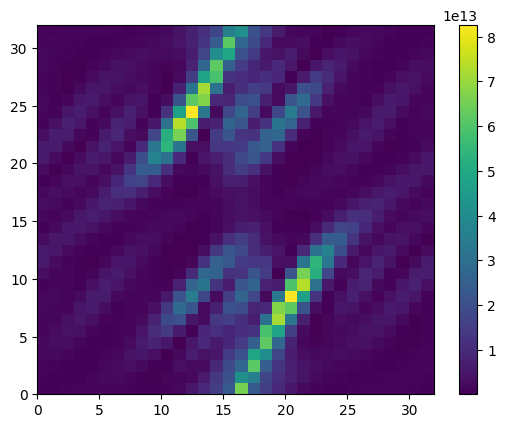

In [36]:
plt.pcolor(K2(qp, nescoil_phi_mn))
plt.colorbar()

In [37]:
print(jnp.min(K_theta(qp, phi_mn)))
print(jnp.max(K_theta(qp, phi_mn)))

11884578.093864469
11884578.094702527


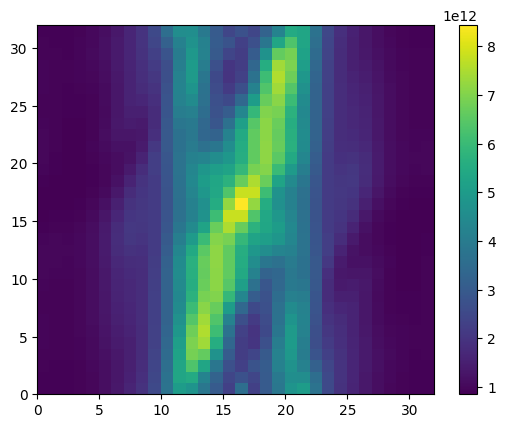

In [38]:
plt.pcolor(K2(qp, phi_mn))
plt.colorbar()

In [39]:
# The current variation is tiny. 

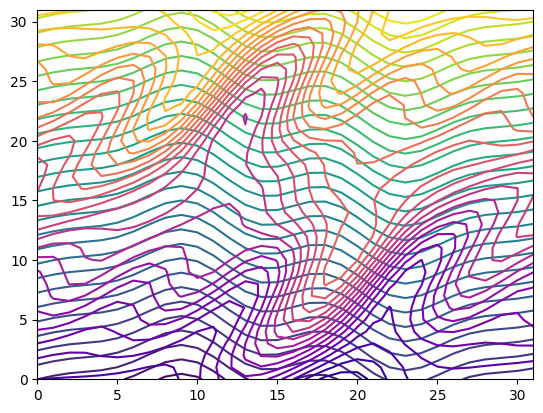

In [40]:
plt.contour(Phi_with_net_current(qp, phi_mn), levels=30)
plt.contour(Phi_with_net_current(qp, nescoil_phi_mn), levels=30, cmap='plasma')